# Deep Convolutional Neural Networks for CIFAR-10 Dataset

In this project I implement a deep neural network using BOTH TensorFlow and Keras.

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

TensorFlow Version 1.3.0


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. I will use all 50,000 images for training and 10,000 images for test.

In [4]:
import os
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    batches = []
    labels = []
    path = "data/cifar-10-batches-py"
    for i in range(1,6):
        batch_file = os.path.join(path, 'data_batch_%d' % (i, ))
        unpickled_data, unpickled_label = unpickle(batch_file)
        data = unpickled_data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        label = np.array(unpickled_label)
        batches.append(data)
        labels.append(label)
    data_train = np.concatenate(batches)
    labels_train = np.concatenate(labels)
    del data, labels
    
    # getting appropriate number of samples
    data_val = data_train[range(num_training, num_training+num_validation)]
    labels_val = labels_train[range(num_training, num_training+num_validation)]
    data_train = data_train[range(num_training)]
    labels_train = labels_train[range(num_training)]
    
    return data_train, labels_train, data_val, labels_val
    

def load_test_data():
    path = "data/cifar-10-batches-py"
    test_file = os.path.join(path, 'test_batch')
    unpickled_data, unpickled_label = unpickle(test_file)
    data_test = unpickled_data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    labels_test = np.array(unpickled_label)
    
    # getting appropriate number of samples
    data_test = data_test[range(num_test)]
    labels_test = labels_test[range(num_test)]
    return data_test, labels_test

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Training a base network using TensorFlow

We implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- I use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'



## Define layers

In [5]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

# Fully_connected Layer
def fully_connected(inputs,units):
    b = tf.get_variable('b', [units], initializer=tf.constant_initializer(0.0))
    return tf.contrib.layers.fully_connected(inputs, units, activation_fn=None,
                                            weights_initializer = tf.random_normal_initializer(0.0, 0.02)) + b

# relu layer
def relu_layer(input):
    return tf.nn.relu(input)


## Base convolutional nueral network

In [6]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)          
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        self.flat = tf.reshape(self.pool2, [-1, 4096])   
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            self.fc3 = fully_connected(self.flat,384)
            self.relu3 = relu_layer(self.fc3)
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            self.fc4 = fully_connected(self.fc3,10)           
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        # normalization
        self.X = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), self.X)
        
        self.is_train = True
        self.keep_prob = 1.0
        self.global_step = tf.Variable(0, trainable=False)

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        learning_rate = tf.train.exponential_decay(5e-4, self.global_step, 500, 0.96)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op, global_step=self.global_step)
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))   

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                feed_dict = {self.X: X_, self.Y: Y_}
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Graph 1. X: epoch, Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            plt.plot(losses, '-o')
            plt.xlabel('Epoch')

            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(2, 1, 2)
            plt.title('Training Accuracy')
            plt.plot(accuracies, '-o')
            plt.xlabel('Epoch')
            plt.gcf().set_size_inches(15, 12)
            plt.show()

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        

            feed_dict = {self.X: X_, self.Y: Y_}

            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 18.984, accuracy = 0.062
iteration (50): loss = 2.067, accuracy = 0.234
iteration (100): loss = 1.744, accuracy = 0.359
iteration (150): loss = 1.845, accuracy = 0.305
iteration (200): loss = 1.803, accuracy = 0.359
iteration (250): loss = 1.816, accuracy = 0.297
iteration (300): loss = 1.503, accuracy = 0.477
iteration (350): loss = 1.494, accuracy = 0.414


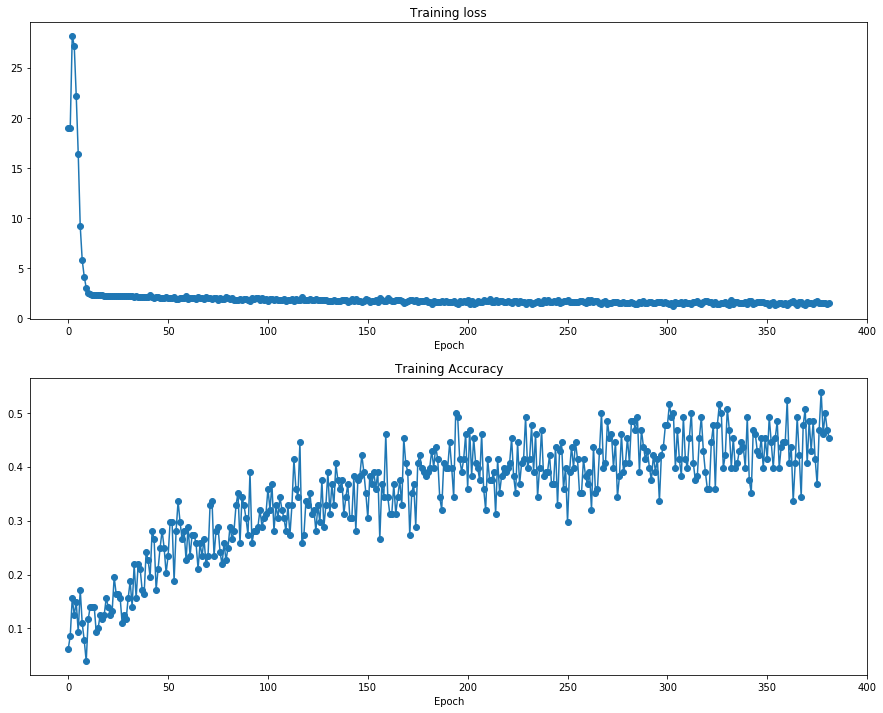

validation for epoch 0
-  epoch 0: validation accuracy = 0.475
train for epoch 1
iteration (400): loss = 1.503, accuracy = 0.461
iteration (450): loss = 1.472, accuracy = 0.438
iteration (500): loss = 1.371, accuracy = 0.461
iteration (550): loss = 1.268, accuracy = 0.562
iteration (600): loss = 1.448, accuracy = 0.492
iteration (650): loss = 1.625, accuracy = 0.484
iteration (700): loss = 1.324, accuracy = 0.539
iteration (750): loss = 1.087, accuracy = 0.641


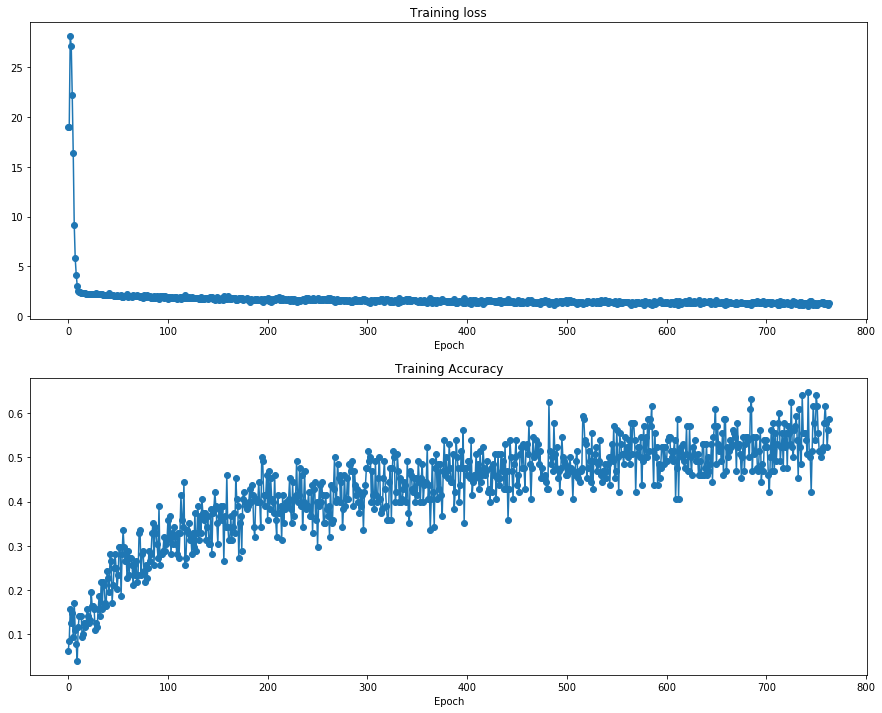

validation for epoch 1
-  epoch 1: validation accuracy = 0.532
train for epoch 2
iteration (800): loss = 1.165, accuracy = 0.562
iteration (850): loss = 1.296, accuracy = 0.547
iteration (900): loss = 1.185, accuracy = 0.609
iteration (950): loss = 1.069, accuracy = 0.625
iteration (1000): loss = 1.156, accuracy = 0.586
iteration (1050): loss = 1.108, accuracy = 0.609
iteration (1100): loss = 1.087, accuracy = 0.617


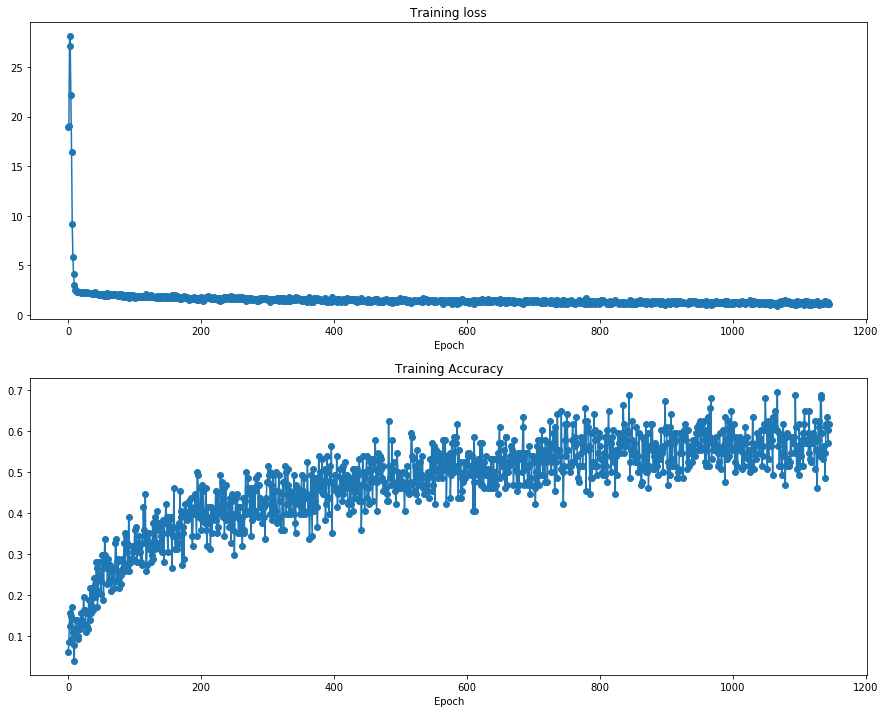

validation for epoch 2
-  epoch 2: validation accuracy = 0.579
train for epoch 3
iteration (1150): loss = 1.151, accuracy = 0.617
iteration (1200): loss = 1.151, accuracy = 0.586
iteration (1250): loss = 1.180, accuracy = 0.594
iteration (1300): loss = 1.293, accuracy = 0.570
iteration (1350): loss = 0.960, accuracy = 0.648
iteration (1400): loss = 1.223, accuracy = 0.617
iteration (1450): loss = 1.143, accuracy = 0.570
iteration (1500): loss = 0.850, accuracy = 0.695


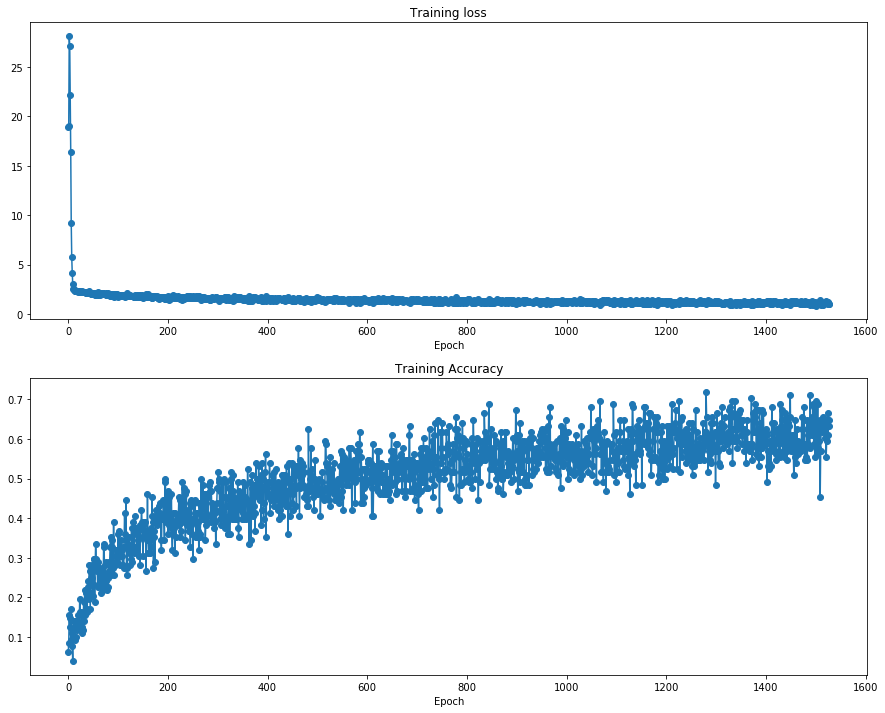

validation for epoch 3
-  epoch 3: validation accuracy = 0.624
train for epoch 4
iteration (1550): loss = 0.860, accuracy = 0.648
iteration (1600): loss = 0.954, accuracy = 0.664
iteration (1650): loss = 1.198, accuracy = 0.617
iteration (1700): loss = 0.991, accuracy = 0.688
iteration (1750): loss = 1.170, accuracy = 0.602
iteration (1800): loss = 1.164, accuracy = 0.562
iteration (1850): loss = 1.011, accuracy = 0.648
iteration (1900): loss = 1.043, accuracy = 0.648


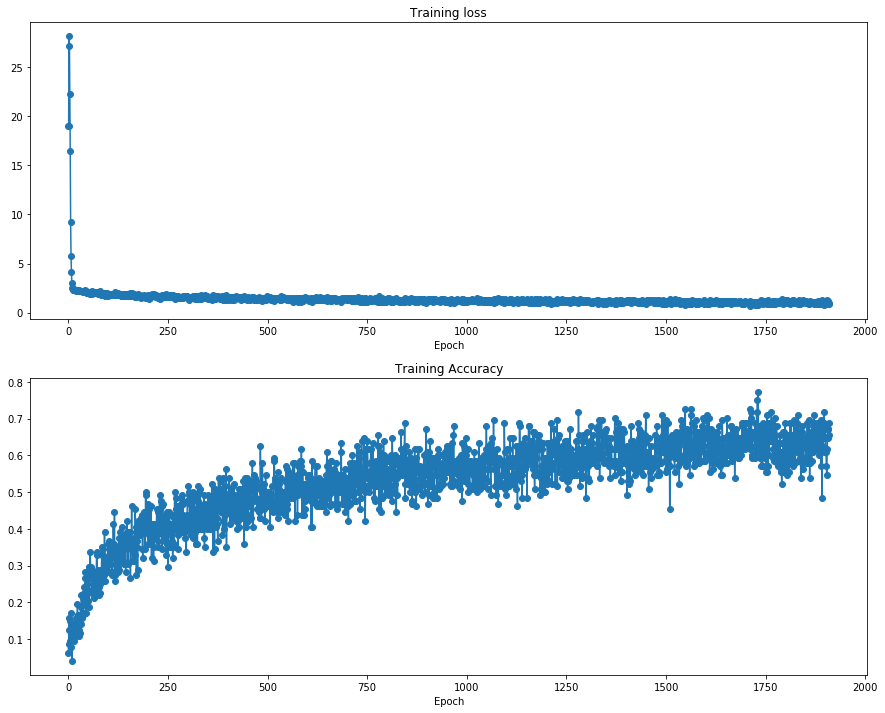

validation for epoch 4
-  epoch 4: validation accuracy = 0.616
***** test accuracy: 0.605
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [7]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    #with tf.device('/gpu:0'):
    model = BaseModel()
    model.train(sess, X_train, Y_train, X_val, Y_val)
    accuracy = model.evaluate(sess, X_test, Y_test)
    print('***** test accuracy: %.3f' % accuracy)
    saver = tf.train.Saver()
    model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
    print("Model saved in %s" % model_path)

# Train a fine-tuned and deep model usin Keras

Here we imporve the above base model by introducing more layers. We also use GPUs for fast training. 

These are the summary of thechniques used for enhancing the model:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

In [8]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import load_model

class YourModel(object):
    def __init__(self):
        self.num_epoch = 15
        self.batch_size = 64
        self.baseDepth = 32
        self.reg_weight = 1e-4
        self.log_step = 50
        self.model = Sequential()
        self._build_model()
        
    
        
    def _build_model(self):
        
        
        self.model.add(Conv2D(self.baseDepth, (3,3), padding='same', kernel_regularizer=regularizers.l2(self.reg_weight),
                         input_shape=(32,32,3)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(self.baseDepth, (3,3), padding='same', kernel_regularizer=regularizers.l2(self.reg_weight)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Dropout(0.2))

        self.model.add(Conv2D(2*self.baseDepth, (3,3), padding='same', kernel_regularizer=regularizers.l2(self.reg_weight)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(2*self.baseDepth, (3,3), padding='same', kernel_regularizer=regularizers.l2(self.reg_weight)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Dropout(0.3))

        self.model.add(Conv2D(4*self.baseDepth, (3,3), padding='same', kernel_regularizer=regularizers.l2(self.reg_weight)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(4*self.baseDepth, (3,3), padding='same', kernel_regularizer=regularizers.l2(self.reg_weight)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Dropout(0.4))

        self.model.add(Flatten())
        self.model.add(Dense(10, activation='softmax'))
        
        self.train_op = keras.optimizers.rmsprop(lr=5e-4,decay=1e-6)
        self.model.compile(loss='categorical_crossentropy', optimizer=self.train_op, metrics=['accuracy'])

        
    def train(self, X_train, Y_train, X_val, Y_val, datagen):

        step = 0
        losses = []
        accuracies = []
        batch_gen = datagen.flow(X_train,Y_train,batch_size = self.batch_size)

        print('-' * 5 + '  Start training  ' + '-' * 5)
        
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                
                X_, Y_ = batch_gen.next()
                self.model.train_on_batch(X_, Y_)
                loss_and_metrics = self.model.evaluate(X_, Y_, batch_size=self.batch_size, verbose=0)
                losses.append(loss_and_metrics[0])
                accuracies.append(loss_and_metrics[1])

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss_and_metrics[0], loss_and_metrics[1]))
                step += 1
                
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            plt.plot(losses, '-o')
            plt.xlabel('Epoch')

            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(2, 1, 2)
            plt.title('Training Accuracy')
            plt.plot(accuracies, '-o')
            plt.xlabel('Epoch')
            plt.gcf().set_size_inches(15, 12)
            plt.show()

            # Print validation results
            print('validation for epoch %d' % epoch)
            loss_and_metrics = self.model.evaluate(X_val, Y_val, verbose=0)
            val_accuracy = loss_and_metrics[1]
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, X_eval, Y_eval):
        loss_and_metrics = self.model.evaluate(X_eval, Y_eval, verbose=0)
        return loss_and_metrics[1]

Using TensorFlow backend.


-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.332, accuracy = 0.109
iteration (50): loss = 2.498, accuracy = 0.094
iteration (100): loss = 2.412, accuracy = 0.172
iteration (150): loss = 3.120, accuracy = 0.047
iteration (200): loss = 2.587, accuracy = 0.266
iteration (250): loss = 2.727, accuracy = 0.250
iteration (300): loss = 2.278, accuracy = 0.234
iteration (350): loss = 1.911, accuracy = 0.328
iteration (400): loss = 1.668, accuracy = 0.453
iteration (450): loss = 1.297, accuracy = 0.531
iteration (500): loss = 1.371, accuracy = 0.531
iteration (550): loss = 1.300, accuracy = 0.562
iteration (600): loss = 1.379, accuracy = 0.547
iteration (650): loss = 1.091, accuracy = 0.688
iteration (700): loss = 0.926, accuracy = 0.672
iteration (750): loss = 1.123, accuracy = 0.594


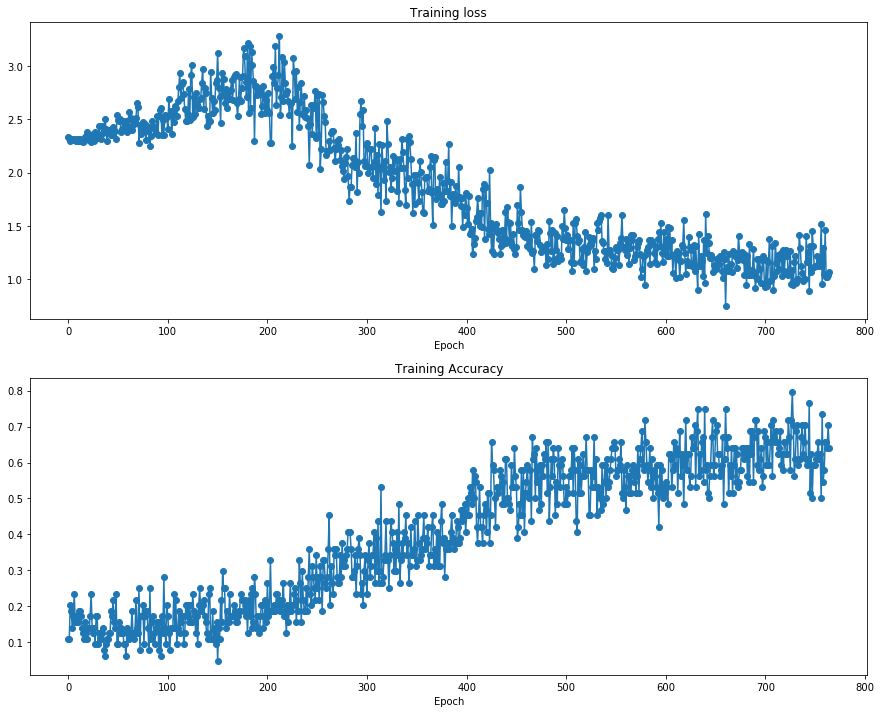

validation for epoch 0
-  epoch 0: validation accuracy = 0.582
train for epoch 1
iteration (800): loss = 1.351, accuracy = 0.531
iteration (850): loss = 1.009, accuracy = 0.625
iteration (900): loss = 1.127, accuracy = 0.594
iteration (950): loss = 1.111, accuracy = 0.688
iteration (1000): loss = 0.915, accuracy = 0.703
iteration (1050): loss = 1.326, accuracy = 0.656
iteration (1100): loss = 0.855, accuracy = 0.719
iteration (1150): loss = 1.114, accuracy = 0.609
iteration (1200): loss = 0.860, accuracy = 0.719
iteration (1250): loss = 0.865, accuracy = 0.688
iteration (1300): loss = 0.913, accuracy = 0.719
iteration (1350): loss = 0.930, accuracy = 0.656
iteration (1400): loss = 1.106, accuracy = 0.609
iteration (1450): loss = 0.882, accuracy = 0.703
iteration (1500): loss = 1.179, accuracy = 0.609


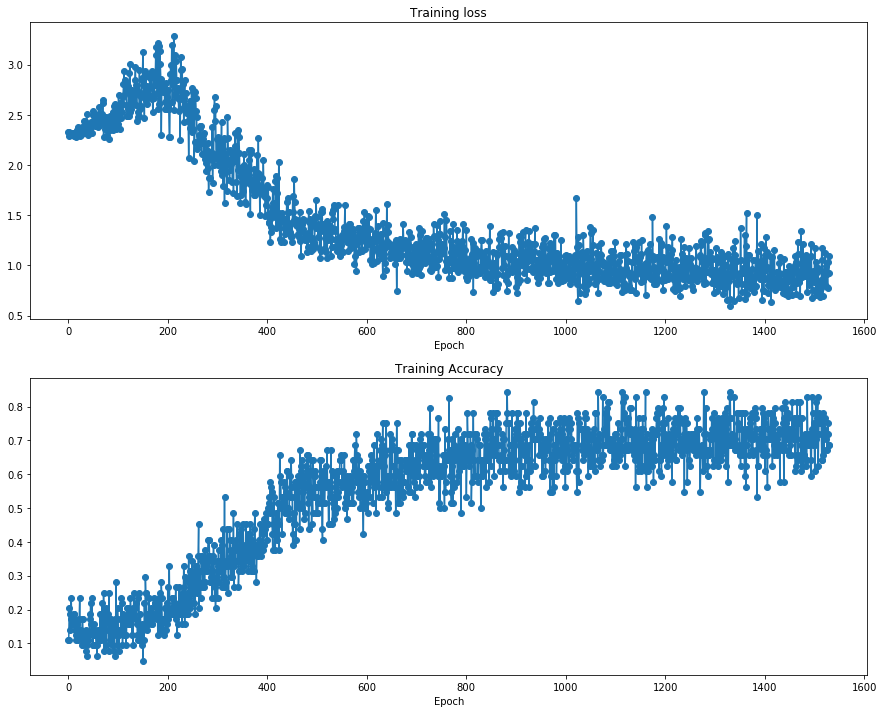

validation for epoch 1
-  epoch 1: validation accuracy = 0.648
train for epoch 2
iteration (1550): loss = 1.201, accuracy = 0.688
iteration (1600): loss = 0.879, accuracy = 0.734
iteration (1650): loss = 0.895, accuracy = 0.688
iteration (1700): loss = 0.726, accuracy = 0.766
iteration (1750): loss = 0.738, accuracy = 0.719
iteration (1800): loss = 0.682, accuracy = 0.781
iteration (1850): loss = 1.068, accuracy = 0.766
iteration (1900): loss = 0.568, accuracy = 0.859
iteration (1950): loss = 0.978, accuracy = 0.641
iteration (2000): loss = 1.196, accuracy = 0.719
iteration (2050): loss = 0.840, accuracy = 0.719
iteration (2100): loss = 0.875, accuracy = 0.719
iteration (2150): loss = 1.047, accuracy = 0.688
iteration (2200): loss = 0.746, accuracy = 0.766
iteration (2250): loss = 0.695, accuracy = 0.844


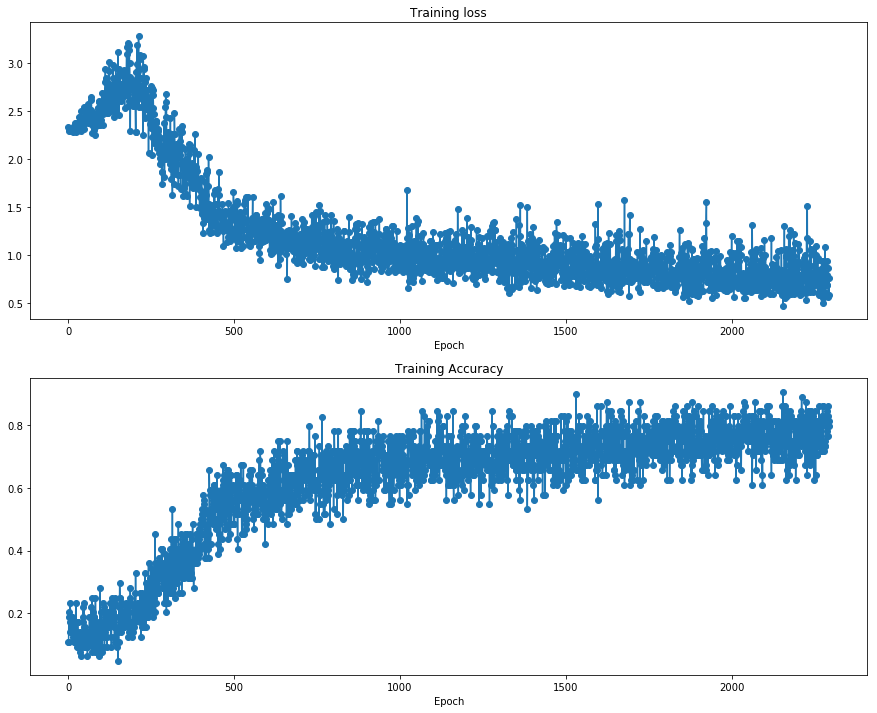

validation for epoch 2
-  epoch 2: validation accuracy = 0.705
train for epoch 3
iteration (2300): loss = 0.879, accuracy = 0.719
iteration (2350): loss = 0.621, accuracy = 0.797
iteration (2400): loss = 0.845, accuracy = 0.781
iteration (2450): loss = 0.938, accuracy = 0.719
iteration (2500): loss = 0.860, accuracy = 0.734
iteration (2550): loss = 0.784, accuracy = 0.766
iteration (2600): loss = 0.652, accuracy = 0.797
iteration (2650): loss = 0.614, accuracy = 0.812
iteration (2700): loss = 0.657, accuracy = 0.781
iteration (2750): loss = 0.745, accuracy = 0.750
iteration (2800): loss = 0.638, accuracy = 0.781
iteration (2850): loss = 0.626, accuracy = 0.812
iteration (2900): loss = 0.763, accuracy = 0.844
iteration (2950): loss = 0.818, accuracy = 0.703
iteration (3000): loss = 1.071, accuracy = 0.625
iteration (3050): loss = 0.811, accuracy = 0.844


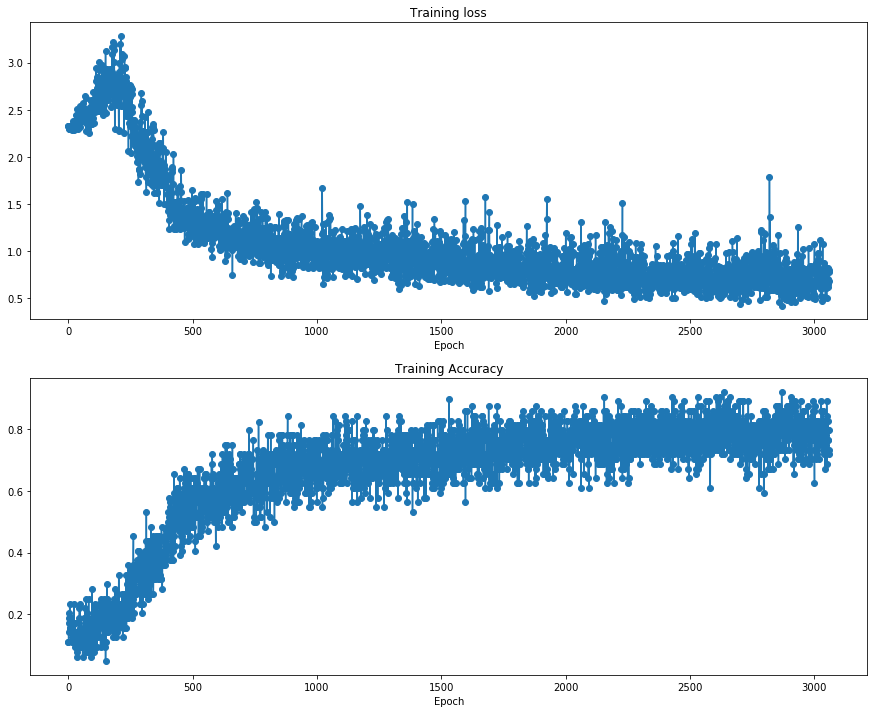

validation for epoch 3
-  epoch 3: validation accuracy = 0.753
train for epoch 4
iteration (3100): loss = 0.570, accuracy = 0.828
iteration (3150): loss = 0.549, accuracy = 0.812
iteration (3200): loss = 0.404, accuracy = 0.859
iteration (3250): loss = 0.649, accuracy = 0.781
iteration (3300): loss = 0.760, accuracy = 0.750
iteration (3350): loss = 0.785, accuracy = 0.766
iteration (3400): loss = 0.621, accuracy = 0.828
iteration (3450): loss = 0.585, accuracy = 0.797
iteration (3500): loss = 0.684, accuracy = 0.906
iteration (3550): loss = 0.638, accuracy = 0.812
iteration (3600): loss = 0.668, accuracy = 0.750
iteration (3650): loss = 0.662, accuracy = 0.750
iteration (3700): loss = 0.623, accuracy = 0.781
iteration (3750): loss = 0.934, accuracy = 0.781
iteration (3800): loss = 0.563, accuracy = 0.828


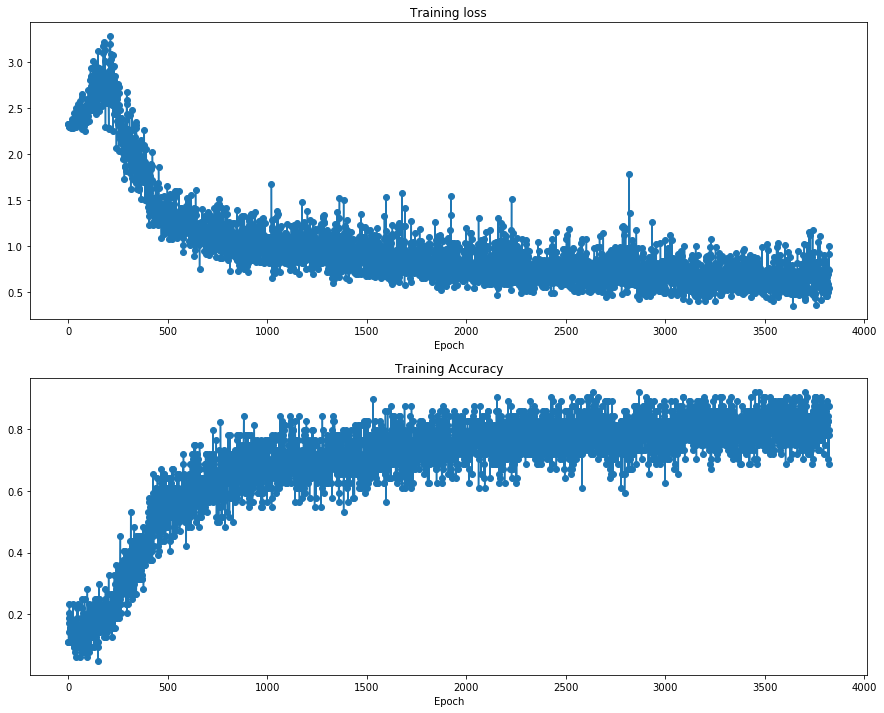

validation for epoch 4
-  epoch 4: validation accuracy = 0.739
train for epoch 5
iteration (3850): loss = 0.665, accuracy = 0.766
iteration (3900): loss = 0.609, accuracy = 0.797
iteration (3950): loss = 0.748, accuracy = 0.812
iteration (4000): loss = 0.656, accuracy = 0.812
iteration (4050): loss = 1.125, accuracy = 0.734
iteration (4100): loss = 0.568, accuracy = 0.812
iteration (4150): loss = 0.590, accuracy = 0.812
iteration (4200): loss = 0.533, accuracy = 0.844
iteration (4250): loss = 0.528, accuracy = 0.844
iteration (4300): loss = 0.761, accuracy = 0.781
iteration (4350): loss = 0.463, accuracy = 0.891
iteration (4400): loss = 0.644, accuracy = 0.750
iteration (4450): loss = 0.779, accuracy = 0.781
iteration (4500): loss = 0.582, accuracy = 0.812
iteration (4550): loss = 0.544, accuracy = 0.828


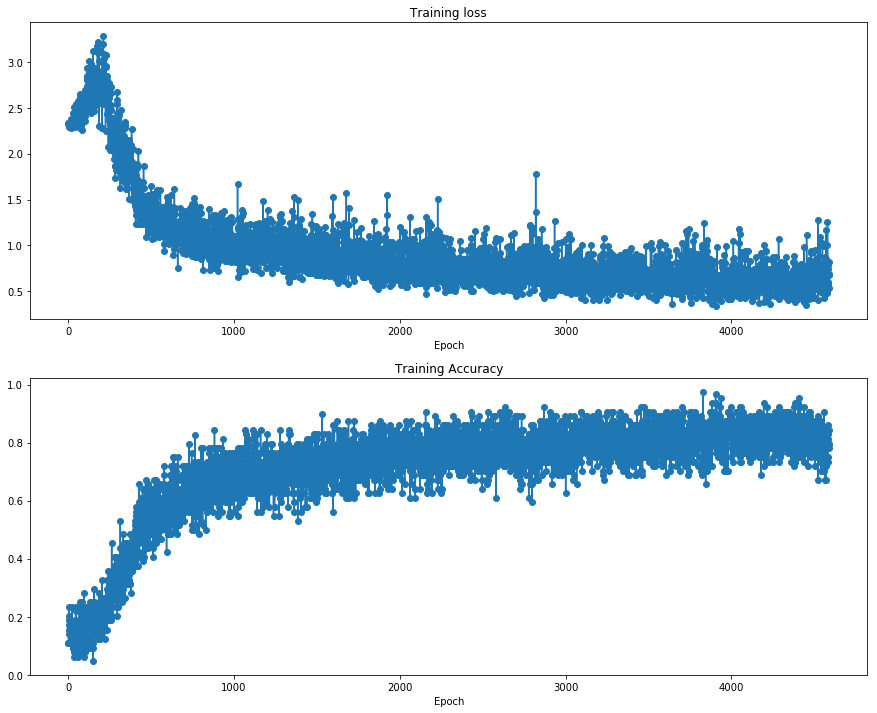

validation for epoch 5
-  epoch 5: validation accuracy = 0.780
train for epoch 6
iteration (4600): loss = 0.492, accuracy = 0.859
iteration (4650): loss = 0.399, accuracy = 0.859
iteration (4700): loss = 0.513, accuracy = 0.859
iteration (4750): loss = 0.601, accuracy = 0.797
iteration (4800): loss = 0.725, accuracy = 0.812
iteration (4850): loss = 0.603, accuracy = 0.766
iteration (4900): loss = 0.578, accuracy = 0.812
iteration (4950): loss = 0.673, accuracy = 0.781
iteration (5000): loss = 0.578, accuracy = 0.734
iteration (5050): loss = 0.430, accuracy = 0.922
iteration (5100): loss = 0.584, accuracy = 0.828
iteration (5150): loss = 0.622, accuracy = 0.797
iteration (5200): loss = 0.512, accuracy = 0.859
iteration (5250): loss = 0.524, accuracy = 0.812
iteration (5300): loss = 0.487, accuracy = 0.875
iteration (5350): loss = 0.765, accuracy = 0.797


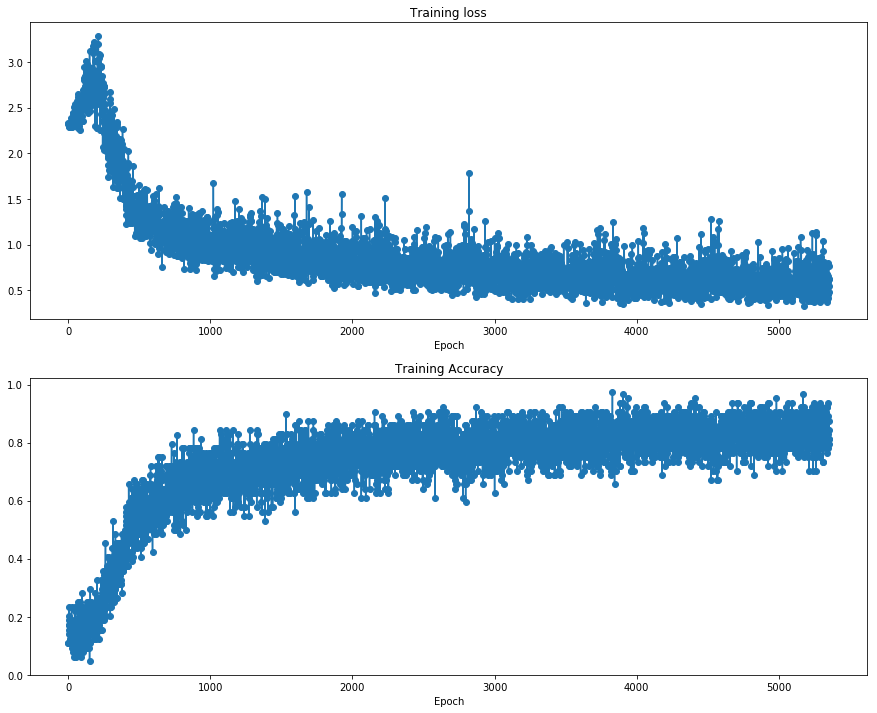

validation for epoch 6
-  epoch 6: validation accuracy = 0.781
train for epoch 7
iteration (5400): loss = 0.502, accuracy = 0.875
iteration (5450): loss = 0.479, accuracy = 0.859
iteration (5500): loss = 0.544, accuracy = 0.875
iteration (5550): loss = 0.377, accuracy = 0.953
iteration (5600): loss = 0.833, accuracy = 0.844
iteration (5650): loss = 0.707, accuracy = 0.844
iteration (5700): loss = 0.467, accuracy = 0.891
iteration (5750): loss = 0.526, accuracy = 0.812
iteration (5800): loss = 0.538, accuracy = 0.844
iteration (5850): loss = 0.442, accuracy = 0.875
iteration (5900): loss = 0.679, accuracy = 0.781
iteration (5950): loss = 0.455, accuracy = 0.875
iteration (6000): loss = 0.452, accuracy = 0.906
iteration (6050): loss = 0.424, accuracy = 0.875
iteration (6100): loss = 0.666, accuracy = 0.797


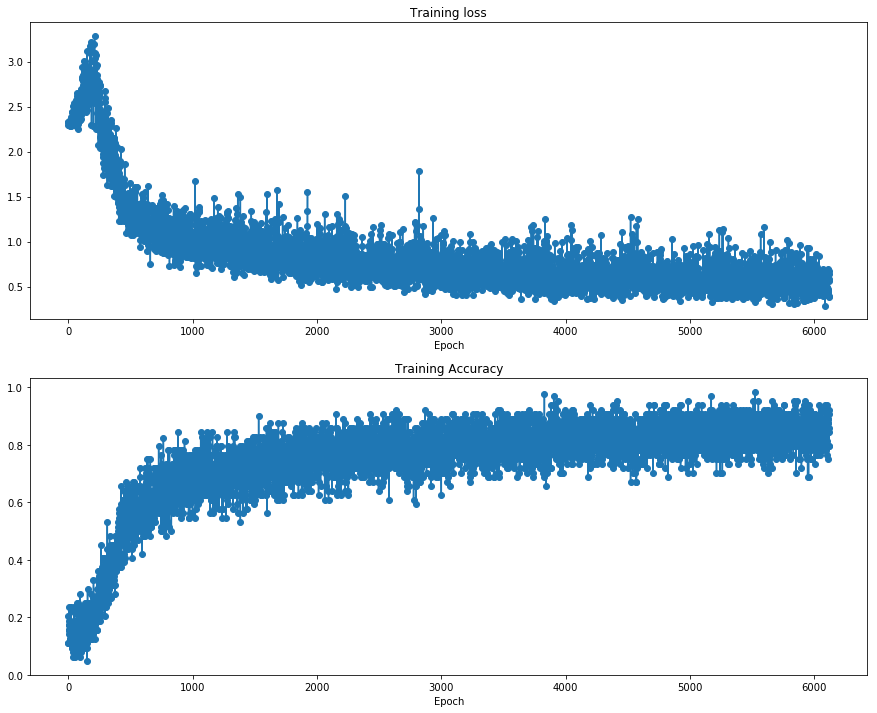

validation for epoch 7
-  epoch 7: validation accuracy = 0.806
train for epoch 8
iteration (6150): loss = 0.519, accuracy = 0.875
iteration (6200): loss = 0.560, accuracy = 0.781
iteration (6250): loss = 0.457, accuracy = 0.875
iteration (6300): loss = 0.579, accuracy = 0.844
iteration (6350): loss = 0.498, accuracy = 0.812
iteration (6400): loss = 0.364, accuracy = 0.938
iteration (6450): loss = 0.441, accuracy = 0.906
iteration (6500): loss = 0.386, accuracy = 0.922
iteration (6550): loss = 0.407, accuracy = 0.891
iteration (6600): loss = 0.599, accuracy = 0.812
iteration (6650): loss = 0.332, accuracy = 0.922
iteration (6700): loss = 0.498, accuracy = 0.859
iteration (6750): loss = 0.559, accuracy = 0.828
iteration (6800): loss = 0.394, accuracy = 0.891
iteration (6850): loss = 0.445, accuracy = 0.859


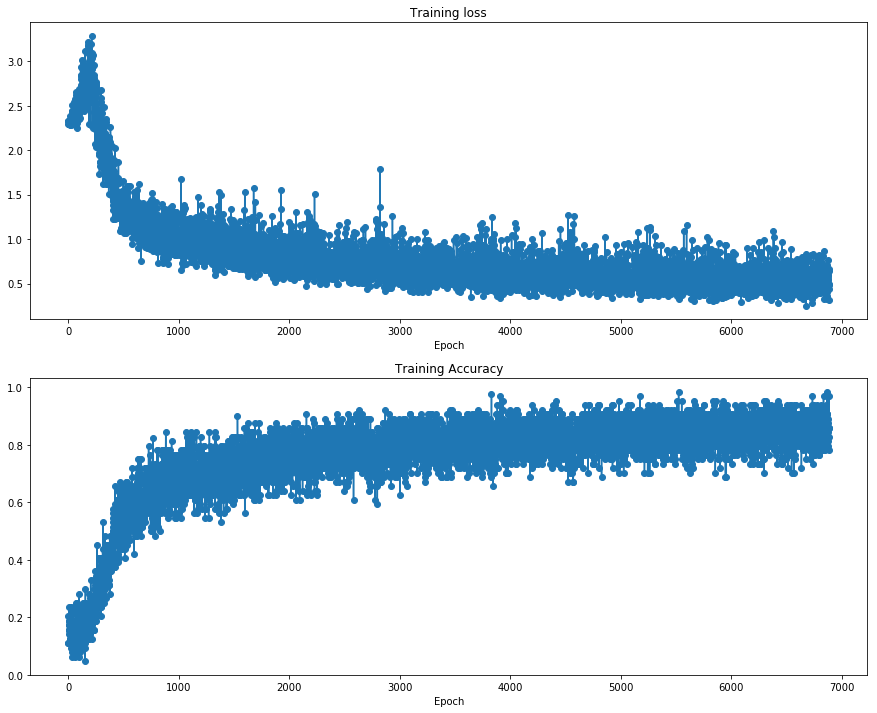

validation for epoch 8
-  epoch 8: validation accuracy = 0.805
train for epoch 9
iteration (6900): loss = 0.510, accuracy = 0.859
iteration (6950): loss = 0.414, accuracy = 0.906
iteration (7000): loss = 0.552, accuracy = 0.828
iteration (7050): loss = 0.484, accuracy = 0.859
iteration (7100): loss = 0.413, accuracy = 0.891
iteration (7150): loss = 0.655, accuracy = 0.797
iteration (7200): loss = 0.679, accuracy = 0.859
iteration (7250): loss = 0.537, accuracy = 0.812
iteration (7300): loss = 0.483, accuracy = 0.844
iteration (7350): loss = 0.560, accuracy = 0.828
iteration (7400): loss = 0.498, accuracy = 0.891
iteration (7450): loss = 0.435, accuracy = 0.891
iteration (7500): loss = 0.436, accuracy = 0.859
iteration (7550): loss = 0.578, accuracy = 0.859
iteration (7600): loss = 0.527, accuracy = 0.875


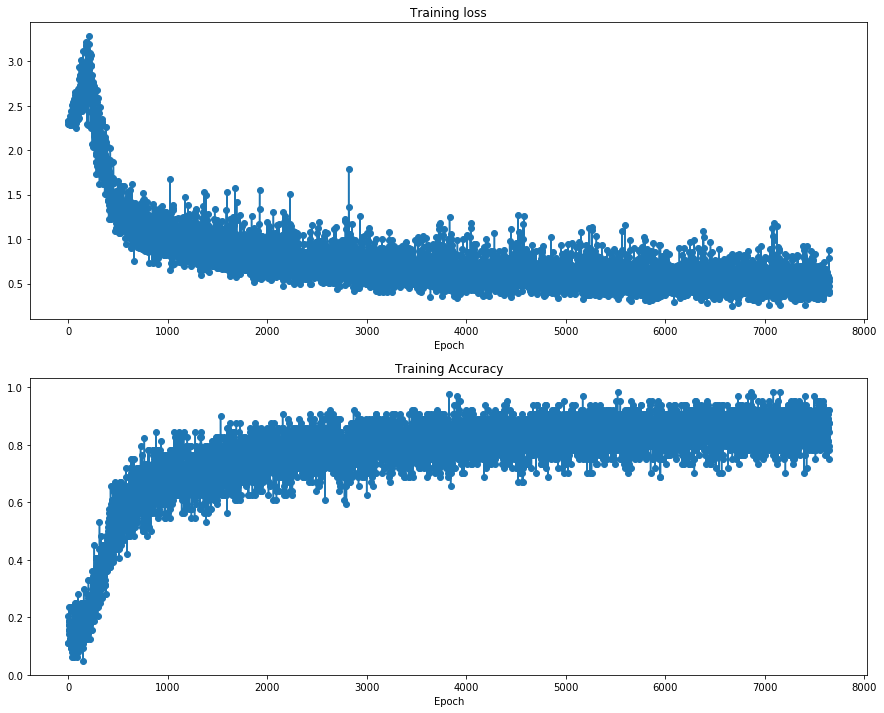

validation for epoch 9
-  epoch 9: validation accuracy = 0.810
train for epoch 10
iteration (7650): loss = 0.649, accuracy = 0.781
iteration (7700): loss = 0.464, accuracy = 0.875
iteration (7750): loss = 0.371, accuracy = 0.922
iteration (7800): loss = 0.529, accuracy = 0.875
iteration (7850): loss = 0.545, accuracy = 0.844
iteration (7900): loss = 0.493, accuracy = 0.844
iteration (7950): loss = 0.432, accuracy = 0.906
iteration (8000): loss = 0.699, accuracy = 0.859
iteration (8050): loss = 0.463, accuracy = 0.828
iteration (8100): loss = 0.581, accuracy = 0.797
iteration (8150): loss = 0.353, accuracy = 0.922
iteration (8200): loss = 0.851, accuracy = 0.734
iteration (8250): loss = 0.655, accuracy = 0.766
iteration (8300): loss = 0.521, accuracy = 0.844
iteration (8350): loss = 0.791, accuracy = 0.766
iteration (8400): loss = 0.504, accuracy = 0.891


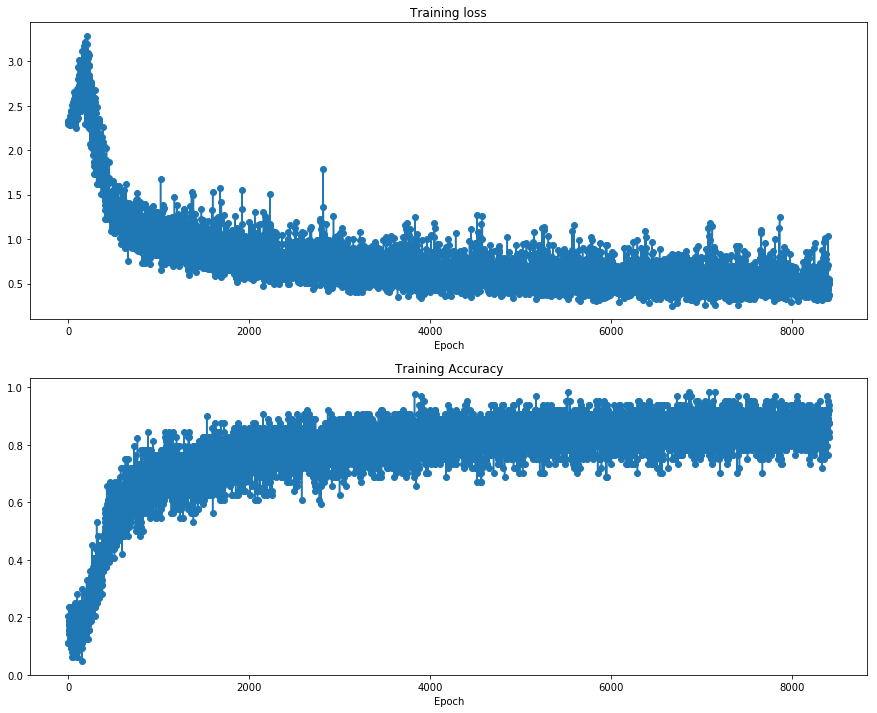

validation for epoch 10
-  epoch 10: validation accuracy = 0.799
train for epoch 11
iteration (8450): loss = 0.593, accuracy = 0.891
iteration (8500): loss = 0.385, accuracy = 0.906
iteration (8550): loss = 0.536, accuracy = 0.828
iteration (8600): loss = 0.439, accuracy = 0.859
iteration (8650): loss = 0.664, accuracy = 0.875
iteration (8700): loss = 0.456, accuracy = 0.891
iteration (8750): loss = 0.564, accuracy = 0.875
iteration (8800): loss = 0.594, accuracy = 0.875
iteration (8850): loss = 0.859, accuracy = 0.828
iteration (8900): loss = 0.439, accuracy = 0.844
iteration (8950): loss = 0.569, accuracy = 0.828
iteration (9000): loss = 0.422, accuracy = 0.891
iteration (9050): loss = 0.419, accuracy = 0.875
iteration (9100): loss = 0.416, accuracy = 0.906
iteration (9150): loss = 0.453, accuracy = 0.875


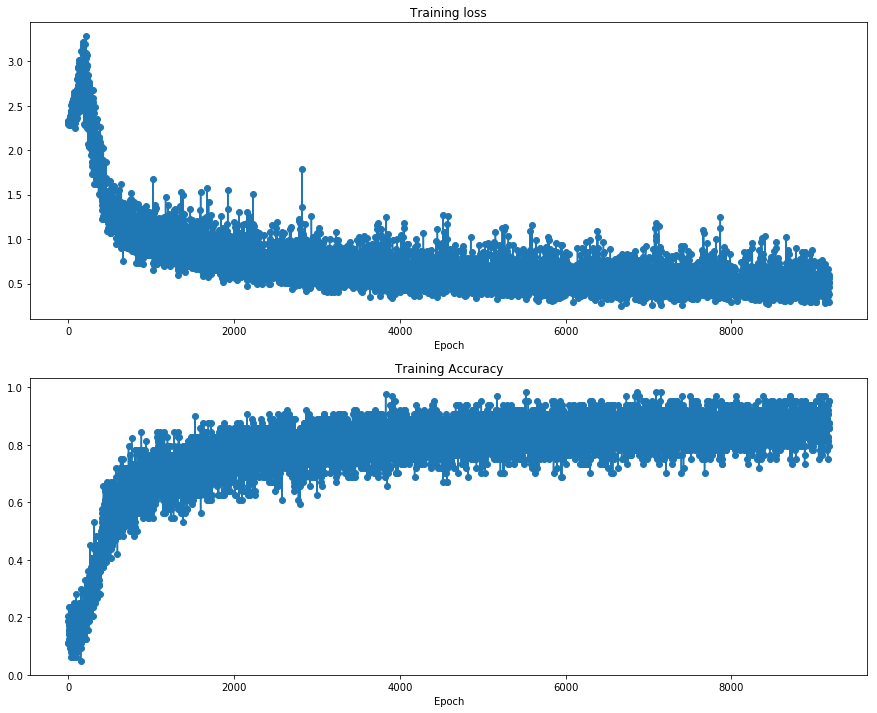

validation for epoch 11
-  epoch 11: validation accuracy = 0.829
train for epoch 12
iteration (9200): loss = 0.370, accuracy = 0.922
iteration (9250): loss = 0.474, accuracy = 0.844
iteration (9300): loss = 0.486, accuracy = 0.859
iteration (9350): loss = 0.368, accuracy = 0.906
iteration (9400): loss = 0.378, accuracy = 0.891
iteration (9450): loss = 0.623, accuracy = 0.828
iteration (9500): loss = 0.449, accuracy = 0.922
iteration (9550): loss = 0.486, accuracy = 0.859
iteration (9600): loss = 0.339, accuracy = 0.938
iteration (9650): loss = 0.545, accuracy = 0.844
iteration (9700): loss = 0.405, accuracy = 0.891
iteration (9750): loss = 0.341, accuracy = 0.891
iteration (9800): loss = 0.607, accuracy = 0.906
iteration (9850): loss = 0.484, accuracy = 0.891
iteration (9900): loss = 0.539, accuracy = 0.844


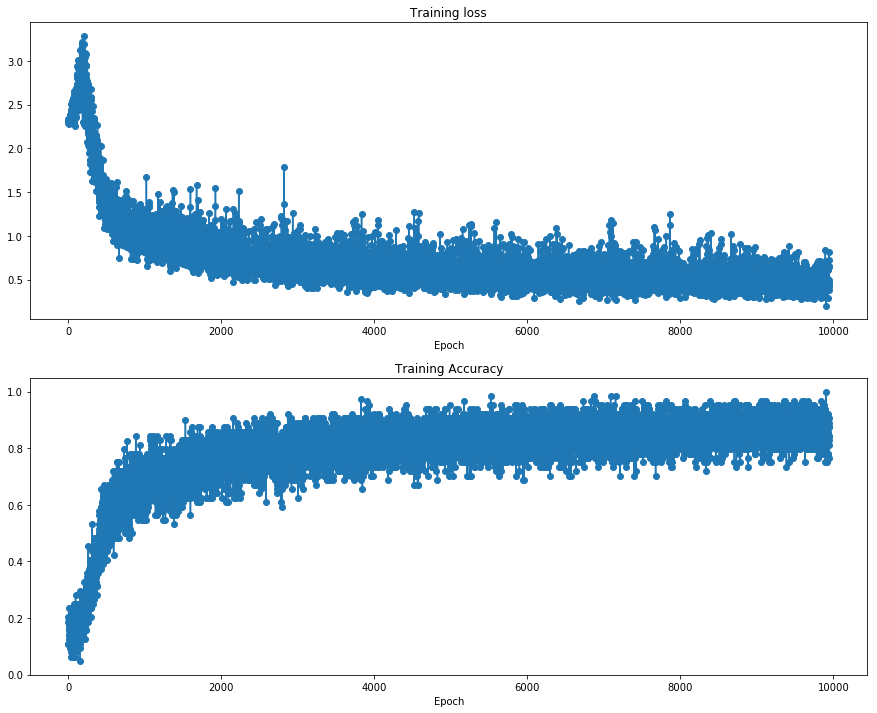

validation for epoch 12
-  epoch 12: validation accuracy = 0.838
train for epoch 13
iteration (9950): loss = 0.468, accuracy = 0.891
iteration (10000): loss = 0.317, accuracy = 0.953
iteration (10050): loss = 0.421, accuracy = 0.922
iteration (10100): loss = 0.553, accuracy = 0.812
iteration (10150): loss = 0.461, accuracy = 0.859
iteration (10200): loss = 0.430, accuracy = 0.906
iteration (10250): loss = 0.634, accuracy = 0.844
iteration (10300): loss = 0.454, accuracy = 0.859
iteration (10350): loss = 0.464, accuracy = 0.828
iteration (10400): loss = 0.330, accuracy = 0.938
iteration (10450): loss = 0.457, accuracy = 0.844
iteration (10500): loss = 0.409, accuracy = 0.891
iteration (10550): loss = 0.481, accuracy = 0.875
iteration (10600): loss = 0.392, accuracy = 0.906
iteration (10650): loss = 0.386, accuracy = 0.891
iteration (10700): loss = 0.414, accuracy = 0.875


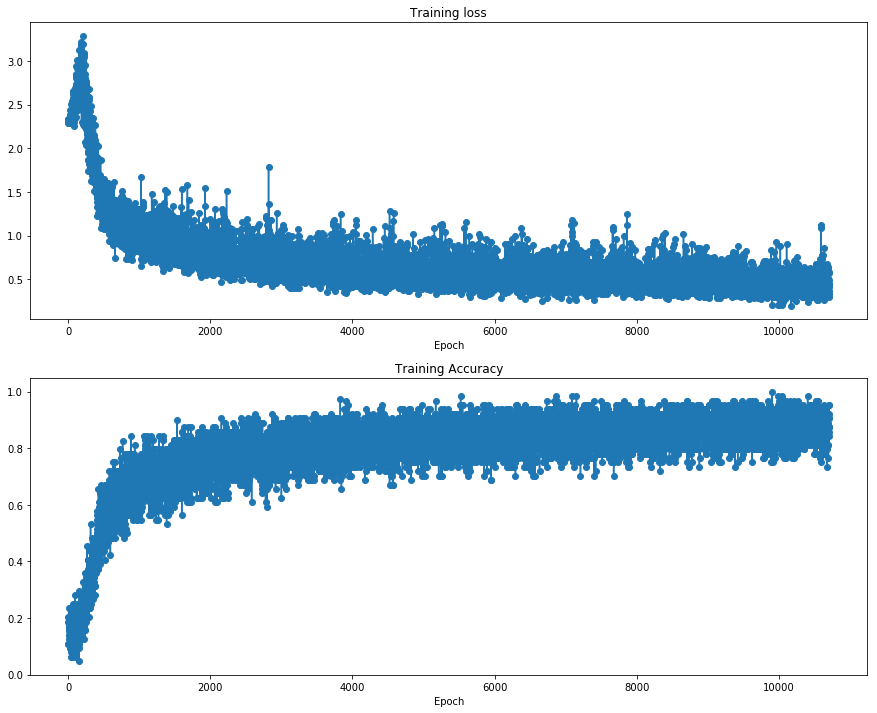

validation for epoch 13
-  epoch 13: validation accuracy = 0.833
train for epoch 14
iteration (10750): loss = 0.432, accuracy = 0.891
iteration (10800): loss = 0.408, accuracy = 0.906
iteration (10850): loss = 0.478, accuracy = 0.875
iteration (10900): loss = 0.395, accuracy = 0.922
iteration (10950): loss = 0.490, accuracy = 0.875
iteration (11000): loss = 0.452, accuracy = 0.875
iteration (11050): loss = 0.366, accuracy = 0.922
iteration (11100): loss = 0.535, accuracy = 0.891
iteration (11150): loss = 0.375, accuracy = 0.891
iteration (11200): loss = 0.450, accuracy = 0.875
iteration (11250): loss = 0.383, accuracy = 0.875
iteration (11300): loss = 0.335, accuracy = 0.938
iteration (11350): loss = 0.312, accuracy = 0.938
iteration (11400): loss = 0.482, accuracy = 0.859
iteration (11450): loss = 0.257, accuracy = 0.938


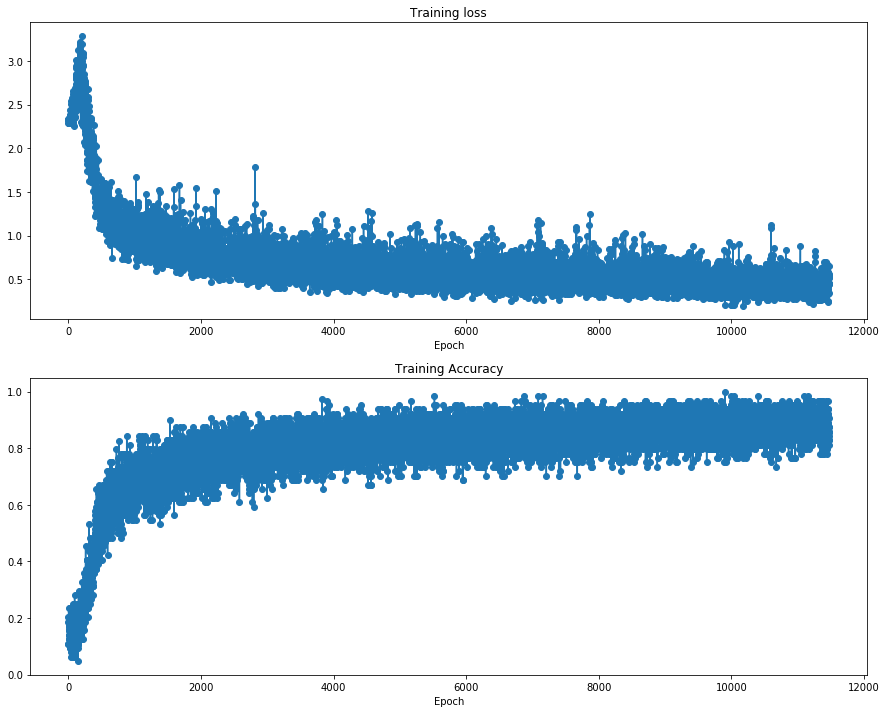

validation for epoch 14
-  epoch 14: validation accuracy = 0.837
***** test accuracy: 0.824
Model saved in ./lib/tf_models/problem2


In [9]:

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

mean = np.mean(X_train,axis=(0,1,2,3))
std = np.std(X_train,axis=(0,1,2,3))
X_train_ = (X_train-mean)/(std+1e-7)
X_test_ = (X_test-mean)/(std+1e-7)
X_val_ = (X_val-mean)/(std+1e-7)

num_classes = 10
Y_train = np_utils.to_categorical(Y_train,num_classes)
Y_test = np_utils.to_categorical(Y_test,num_classes)
Y_val = np_utils.to_categorical(Y_val,num_classes)

# Data Augmentation 
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train_)

model = YourModel()
model.train(X_train_, Y_train, X_val_, Y_val, datagen)
accuracy = model.evaluate(X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
model.model.save('lib/tf_models/problem2/csci-599_mine.ckpt')
print("Model saved in %s" % './lib/tf_models/problem2')



In [10]:
del model

# Load your model
model = YourModel()
model.model = load_model('lib/tf_models/problem2/csci-599_mine.ckpt')